In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from umap.parametric_umap import ParametricUMAP

2024-10-07 00:03:52.386835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 00:03:52.389964: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 00:03:52.399639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 00:03:52.415319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 00:03:52.419760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 00:03:52.431424: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
data = np.load("data/ihb.npy")

In [ ]:
# Check the shape of the data
print("Original shape:", data.shape)  # Should be (320, 10, 246)

# Create a mask to identify samples with NaNs in the last dimension
mask_nan = np.isnan(data).any(axis=(1, 2))

# Split the data into two arrays
data_no_nans = data[~mask_nan]  # Samples without NaNs
data_with_nans = data[mask_nan][:, :, :200]  # Samples with NaNs

# Output shapes of the split arrays
print("Shape of data without NaNs:", data_no_nans.shape)
print("Shape of data with NaNs:", data_with_nans.shape)

Original shape: (320, 10, 246)
Shape of data without NaNs: (160, 10, 246)
Shape of data with NaNs: (160, 10, 200)


In [ ]:
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)

    # Z-normalize the data
    normalized_data = (data - mean) / std

    # The shape of normalized_data will be (160, 10, 246)
    return normalized_data


# data_no_nans = normalize(data_no_nans)
# data_with_nans = normalize(data_with_nans)

In [ ]:
def fisher_transform(corr):
    # return corr
    # Clip values to avoid issues with arccosh for values very close to -1 or 1
    corr = np.clip(corr, -0.999999, 0.999999)
    return 0.5 * np.log((1 + corr) / (1 - corr))

In [ ]:
def get_corr_matrics(some_data):

    correlation_matrices = []

    # Loop over each scan
    for i in range(some_data.shape[0]):
        # Get the time series for all brain regions in this scan (shape: 10, 246)
        time_series = some_data[i, :, :]

        # Compute the Pearson correlation matrix (shape: 246, 246)
        corr_matrix = np.corrcoef(time_series, rowvar=False)

        # Append the correlation matrix to the list
        correlation_matrices.append(corr_matrix)

    # Convert the list to a numpy array (shape: 320, 246, 246)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return fisher_transform(correlation_matrices)

In [ ]:
def get_windowed_corr_matrices(some_data, window_length, step_size=None):
    """
    Calculate correlation matrices in a sliding window fashion.

    Parameters:
        some_data: 3D numpy array (n_samples, n_timepoints, n_rois)
        window_length: Length of the sliding window (number of time points)
        step_size: Step size for the sliding window. If None, it defaults to the window_length.

    Returns:
        correlation_matrices: 4D numpy array (n_samples, n_windows, n_rois, n_rois)
    """
    n_samples, n_timepoints, n_rois = some_data.shape

    # Default step size to the window length if not provided
    if step_size is None:
        step_size = window_length

    # Calculate the number of windows
    n_windows = (n_timepoints - window_length) // step_size + 1

    # Initialize a list to hold correlation matrices for all windows
    correlation_matrices = []

    # Loop over each scan
    for i in range(n_samples):
        time_series = some_data[
            i, :, :
        ]  # Get the time series for this scan (shape: n_timepoints, n_rois)

        # Initialize a list to hold correlation matrices for this sample
        sample_corr_matrices = []

        # Compute correlation matrices for each window
        for start in range(0, n_timepoints - window_length + 1, step_size):
            window = time_series[
                start : start + window_length, :
            ]  # Extract the current window
            corr_matrix = np.corrcoef(
                window, rowvar=False
            )  # Compute the Pearson correlation matrix
            sample_corr_matrices.append(fisher_transform(corr_matrix))

        # Append the sample's correlation matrices to the main list
        correlation_matrices.append(sample_corr_matrices)

    # Convert the list to a numpy array (shape: n_samples, n_windows, n_rois, n_rois)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return correlation_matrices

In [ ]:
# Assuming your correlation matrix is named `correlation_matrices`
# with shape (320, 246, 246)
# def apply_transforms(correlation_matrices):
#     # Step 1: Fisher's r-to-z transformation
#     def fisher_transform(corr):
#         # Clip values to avoid issues with arccosh for values very close to -1 or 1
#         corr = np.clip(corr, -0.999999, 0.999999)
#         return 0.5 * np.log((1 + corr) / (1 - corr))

#     # Apply Fisher transformation to each correlation matrix
#     z_matrices = fisher_transform(correlation_matrices)

#     # Step 2: Pseudo z-scoring
#     # Here we will standardize each matrix (mean = 0, std = 1)
#     def pseudo_z_score(z_matrices):
#         # Calculate mean and std along the last two dimensions (246, 246)
#         mean = np.mean(z_matrices, axis=(1, 2), keepdims=True)
#         std = np.std(z_matrices, axis=(1, 2), keepdims=True)

#         # Standardize
#         return (z_matrices - mean) / std

#     # Apply pseudo z-scoring
#     return pseudo_z_score(z_matrices)

In [ ]:
no_nans_windowed = get_windowed_corr_matrices(data_no_nans, 3)
with_nans_windowed = get_windowed_corr_matrices(data_with_nans, 3)

no_nans_corr = get_corr_matrics(data_no_nans)
with_nans_corr = get_corr_matrics(data_with_nans)


def concatenate_stuff(one, two_windowed):

    # Add a new axis to tensor2 to make it (160, 1, 246, 246)
    tensor2_expanded = np.expand_dims(one, axis=1)  # Shape (160, 1, 246, 246)

    # Concatenate along the channel dimension (axis 1)
    result = np.concatenate((two_windowed, tensor2_expanded), axis=1)
    return result


no_nans_super_final = concatenate_stuff(no_nans_corr, no_nans_windowed)
with_nans_super_final = concatenate_stuff(with_nans_corr, with_nans_windowed)

Shape of correlation matrices: (160, 3, 246, 246)
Shape of correlation matrices: (160, 3, 200, 200)
Shape of correlation matrices: (160, 246, 246)
Shape of correlation matrices: (160, 200, 200)


In [ ]:
# Function to extract the upper triangle of the correlation matrix, excluding the diagonal


def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]  # k=1 excludes the diagonal

In [ ]:
flattened_matrices_nans = np.array(
    [
        [flatten_upper_triangle(matrix) for matrix in sample]
        for sample in no_nans_super_final
    ]
)

flattened_matrices_no_nans = np.array(
    [
        [flatten_upper_triangle(matrix) for matrix in sample]
        for sample in with_nans_super_final
    ]
)

# Concatenate all flattened vectors into a single vector for each sample
concatenated_nans = np.array(
    [np.concatenate(sample) for sample in flattened_matrices_nans]
)
concatenated_no_nans = np.array(
    [np.concatenate(sample) for sample in flattened_matrices_no_nans]
)

# Output the shapes of the concatenated results
print(
    "Concatenated vector shape (with NaNs):", concatenated_nans.shape
)  # Expected shape (160, num_flattened_features)
print("Concatenated vector shape (without NaNs):", concatenated_no_nans.shape)

Concatenated vector shape (with NaNs): (160, 120540)
Concatenated vector shape (without NaNs): (160, 79600)


In [ ]:
# # Assuming `correlation_matrices` is of shape (320, 246, 246)


# # Flatten each 246x246 correlation matrix into a 1D vector (upper triangle only)
# flattened_matrices_nans = np.array(
#     [flatten_upper_triangle(matrix) for matrix in with_nans_corr]
# )

# flattened_matrices_no_nans = np.array(
#     [flatten_upper_triangle(matrix) for matrix in no_nans_corr]
# )

# print("Shape of flattened matrices with NaNs:", flattened_matrices_nans.shape)
# print("Shape of flattened matrices without NaNs:", flattened_matrices_no_nans.shape)

In [ ]:
# def create_time_features(data):
#     mean_features = np.mean(data, axis=1)
#     median_features = np.median(data, axis=1)
#     percentile_25 = np.percentile(data, 15, axis=1)
#     percentile_75 = np.percentile(data, 75, axis=1)
#     percentile_10 = np.percentile(data, 10, axis=1)
#     percentile_90 = np.percentile(data, 90, axis=1)
#     min_features = np.min(data, axis=1)
#     max_features = np.max(data, axis=1)
#     std = np.std(data, axis=1)
#     count_zeros = np.sum(data == 0, axis=1)
#     abs_sum_changes = np.sum(np.abs(np.diff(data, axis=1)), axis=1)
#     return np.concatenate(
#         [
#             mean_features,
#             median_features,
#             percentile_25,
#             percentile_75,
#             percentile_10,
#             percentile_90,
#             min_features,
#             max_features,
#             std,
#             count_zeros,
#             abs_sum_changes
#         ],
#         axis=1,
#     )

In [ ]:
# Set UMAP parameters
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 50  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_nans = umap_model_nans.fit_transform(concatenated_nans)

# Apply UMAP to the data without NaN values
umap_model_no_nans = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_no_nans = umap_model_no_nans.fit_transform(concatenated_no_nans)

# Concatenate the UMAP results
flattened_matrices = np.concatenate((umap_result_nans, umap_result_no_nans), axis=0)

print("Shape of flattened matrices:", flattened_matrices.shape)

/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of flattened matrices: (320, 50)


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


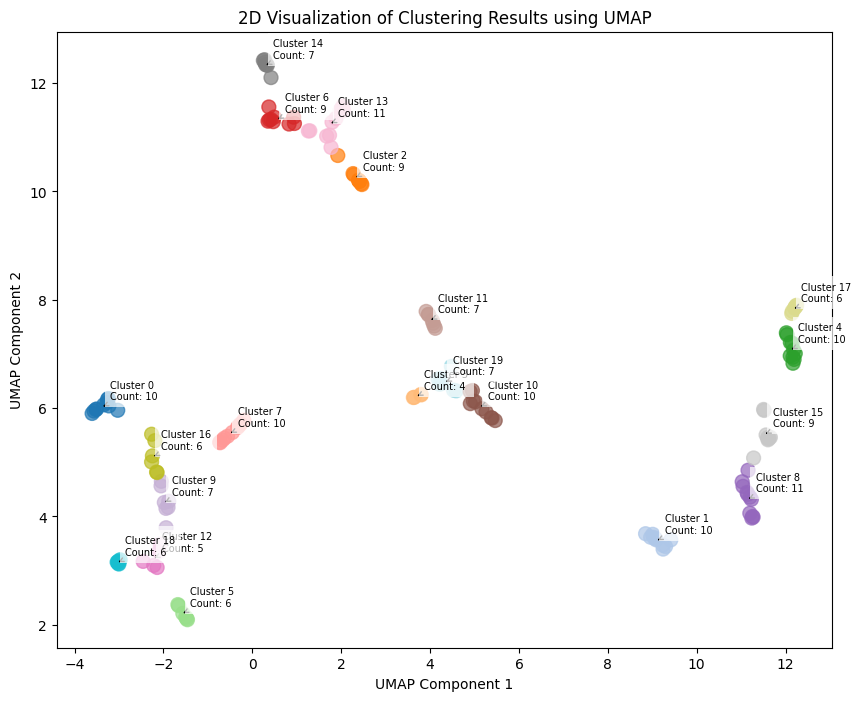

In [ ]:
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=8,
    min_dist=0.001,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(umap_result_nans)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
# kmeans = SpectralClustering(n_clusters=num_clusters, random_state=42)
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


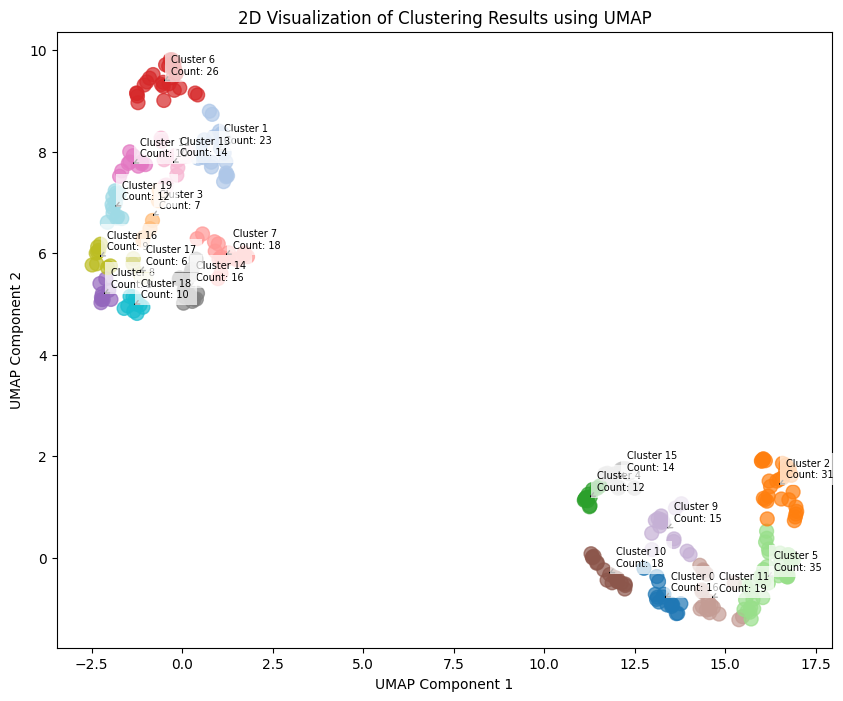

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 2 dimensions
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=16,
    min_dist=0.1,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

In [ ]:
pd.DataFrame({"pred": cluster_labels}).value_counts()

pred
6       30
13      25
2       24
3       24
10      22
7       21
0       21
4       19
8       16
18      14
19      14
12      13
14      13
15      12
5       11
9       10
17      10
11       8
16       7
1        6
Name: count, dtype: int64

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("submissions/" + "bullshit_new_3.csv", index=False)